# Extract Relative Pose
This script is used to convert ground truth scripts with absolute poses to relative poses for RPR

In [1]:
import numpy as np
import os
import pandas as pd
from utils import convert_body_to_world, obtain_relative_pose, obtain_relative_orientation, obtain_absolute_pose, obtain_absolute_orientation, get_translation_from_imu, integrate_angular_velocity

In [2]:
data_root = 'D:/Imperial/FYP/captured_data/airsim_drone_mode/relative_pose/building_relative_v4'
train_or_val = 'val'
airsim_rec_file = 'airsim_rec_0.txt'
time_lag = 1
train_data = pd.read_csv(os.path.join(data_root, train_or_val, airsim_rec_file), sep="\t")
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["prev_timestamp"] = train_data["timestamp"].shift(time_lag)

# Pair poses up with previous frame pose
train_data["prev_POS_X"] = train_data["POS_X"].shift(time_lag)
train_data["prev_POS_Y"] = train_data["POS_Y"].shift(time_lag)
train_data["prev_POS_Z"] = train_data["POS_Z"].shift(time_lag)
train_data["prev_Q_W"] = train_data["Q_W"].shift(time_lag)
train_data["prev_Q_X"] = train_data["Q_X"].shift(time_lag)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(time_lag)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(time_lag)

# Pair poses up with previous velocity, previous acceleration
train_data["prev_LIN_VEL_X"] = train_data["LIN_VEL_X"].shift(time_lag)
train_data["prev_LIN_VEL_Y"] = train_data["LIN_VEL_Y"].shift(time_lag)
train_data["prev_LIN_VEL_Z"] = train_data["LIN_VEL_Z"].shift(time_lag)
train_data["prev_LIN_ACC_X"] = train_data["LIN_ACC_X"].shift(time_lag)
train_data["prev_LIN_ACC_Y"] = train_data["LIN_ACC_Y"].shift(time_lag)
train_data["prev_LIN_ACC_Z"] = train_data["LIN_ACC_Z"].shift(time_lag)
train_data["prev_ANG_VEL_X"] = train_data["ANG_VEL_X"].shift(time_lag)
train_data["prev_ANG_VEL_Y"] = train_data["ANG_VEL_Y"].shift(time_lag)
train_data["prev_ANG_VEL_Z"] = train_data["ANG_VEL_Z"].shift(time_lag)

# Calculate timestep from previous frame
train_data["timestep"] = ((train_data["timestamp"] - train_data["prev_timestamp"]).dt.total_seconds())

# Previous frame image filename
train_data['ImageFile'] = train_or_val + '/images_0/' + train_data['ImageFile'].astype(str)
train_data['prev_ImageFile'] = train_data['ImageFile'].shift(time_lag)


In [3]:
train_data.head()

,Vehicle_name,timestamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,LIN_ACC_X,...,prev_LIN_VEL_Y,prev_LIN_VEL_Z,prev_LIN_ACC_X,prev_LIN_ACC_Y,prev_LIN_ACC_Z,prev_ANG_VEL_X,prev_ANG_VEL_Y,prev_ANG_VEL_Z,timestep,prev_ImageFile
0,,2022-05-13 17:19:11.057667584,-7.471589,-7.297866,-2.824034,1.000000,-0.000506,0.000531,0.000033,-0.011140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-13 17:19:11.308151552,-7.468446,-7.286850,-2.804012,0.996271,0.072833,-0.007932,0.045577,0.127642,...,0.013831,0.051230,-0.011140,-0.010631,-0.177374,-0.008634,0.008874,0.000069,0.250484,val/images_0/0.png
2,,2022-05-13 17:19:11.561635328,-7.458852,-7.187167,-2.836372,0.969235,0.081477,-0.025924,0.230809,0.121263,...,0.282382,-0.050150,0.127642,1.951442,-1.867890,0.188502,-0.052046,1.286254,0.253484,val/images_0/1.png
3,,2022-05-13 17:19:11.818118912,-7.442213,-6.990725,-2.880651,0.880282,0.057999,-0.037450,0.469400,0.098987,...,0.738336,-0.203972,0.121263,1.558641,0.345132,-0.102218,0.073565,2.052330,0.256484,val/images_0/2.png
4,,2022-05-13 17:19:12.062603264,-7.411184,-6.621276,-2.907853,0.693563,0.028762,-0.035189,0.718961,0.068260,...,1.089757,-0.107986,0.098987,1.180840,0.325863,-0.049608,0.149738,2.320805,0.244484,val/images_0/3.png


## Convert IMU Acceleration to world frame

In [4]:
train_data["S_LIN_ACC_X_world"] = train_data.apply(lambda row : convert_body_to_world(np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float),
                                                                                      np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))[0], 
                                                    axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.apply(lambda row : convert_body_to_world(np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float),
                                                                                      np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))[1], 
                                                    axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.apply(lambda row : convert_body_to_world(np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float),
                                                                                      np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))[2],
                                                    axis = 1)

# Pair poses up with previous velocity, previous acceleration (IMU)
train_data["prev_S_LIN_ACC_X_world"] = train_data["S_LIN_ACC_X_world"].shift(time_lag)
train_data["prev_S_LIN_ACC_Y_world"] = train_data["S_LIN_ACC_Y_world"].shift(time_lag)
train_data["prev_S_LIN_ACC_Z_world"] = train_data["S_LIN_ACC_Z_world"].shift(time_lag)
train_data["prev_S_ANG_VEL_X"] = train_data["S_ANG_VEL_X"].shift(time_lag)
train_data["prev_S_ANG_VEL_Y"] = train_data["S_ANG_VEL_Y"].shift(time_lag)
train_data["prev_S_ANG_VEL_Z"] = train_data["S_ANG_VEL_Z"].shift(time_lag)

# Ignore first row as there is no previous frame
train_data = train_data.iloc[time_lag:, :].reset_index()

<AxesSubplot:>

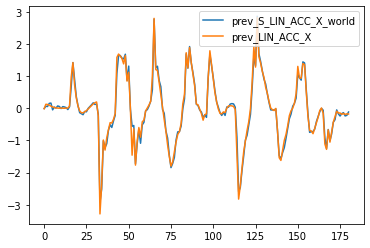

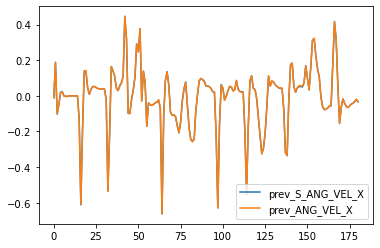

In [5]:
train_data[["prev_S_LIN_ACC_X_world", "prev_LIN_ACC_X"]].plot()
train_data[["prev_S_ANG_VEL_X", "prev_ANG_VEL_X"]].plot()

## Calculate True Relative Poses

In [6]:
train_data["relative_pose"] = train_data.apply(lambda row: 
                                                    obtain_relative_pose(
                                                        np.hstack([row["POS_X"], row["POS_Y"], row["POS_Z"], row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]]), 
                                                        np.hstack([row["prev_POS_X"], row["prev_POS_Y"], row["prev_POS_Z"], row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])
                                                    ), axis=1)


In [7]:
relative_poses = pd.DataFrame(train_data["relative_pose"].to_list(), columns=["rel_POS_X", "rel_POS_Y", "rel_POS_Z", "rel_Q_W", "rel_Q_X","rel_Q_Y","rel_Q_Z"])
train_data = pd.concat([train_data, relative_poses], axis=1)

## See distribution of relative poses

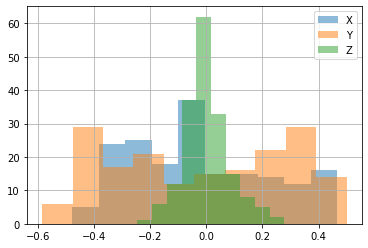

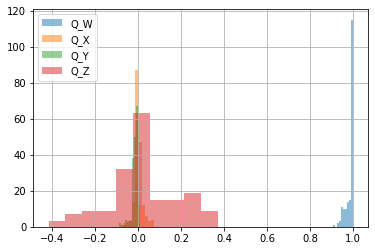

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(np.vstack(train_data["relative_pose"])[:,0], label="X", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,1], label="Y", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,2], label="Z", alpha=0.5)
plt.legend()
plt.grid()

plt.figure()
plt.hist(np.vstack(train_data["relative_pose"])[:,3], label="Q_W", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,4], label="Q_X", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,5], label="Q_Y", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,6], label="Q_Z", alpha=0.5)
plt.legend()
plt.grid()

## Calculate relative pose from IMU
Still not sure if we should do rotation matrix or quartenions

In [10]:
train_data["imu_rel_POS_X"] = train_data.apply(lambda row : -get_translation_from_imu(row["prev_LIN_VEL_X"], row["prev_S_LIN_ACC_X_world"], row["timestep"]), axis=1)
train_data["imu_rel_POS_Y"] = train_data.apply(lambda row : -get_translation_from_imu(row["prev_LIN_VEL_Y"], row["prev_S_LIN_ACC_Y_world"], row["timestep"]), axis=1)
train_data["imu_rel_POS_Z"] = train_data.apply(lambda row : -get_translation_from_imu(row["prev_LIN_VEL_Z"], row["prev_S_LIN_ACC_Z_world"], row["timestep"]), axis=1)

train_data["imu_pred_Q_W"] = train_data.apply(lambda row: integrate_angular_velocity(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]),
                                                                                     np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                                                                     row["timestep"])[0], 
                                              axis=1)
train_data["imu_pred_Q_X"] = train_data.apply(lambda row: integrate_angular_velocity(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]),
                                                                                     np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                                                                     row["timestep"])[1], 
                                              axis=1)
train_data["imu_pred_Q_Y"] = train_data.apply(lambda row: integrate_angular_velocity(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]),
                                                                                     np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                                                                     row["timestep"])[2], 
                                              axis=1)
train_data["imu_pred_Q_Z"] = train_data.apply(lambda row: integrate_angular_velocity(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]),
                                                                                     np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                                                                     row["timestep"])[3], 
                                              axis=1)
train_data["imu_relative_orientation"] = train_data.apply(lambda row: 
                                                            obtain_relative_orientation(
                                                                np.hstack([row["imu_pred_Q_W"], row["imu_pred_Q_X"], row["imu_pred_Q_Y"], row["imu_pred_Q_Z"]]), 
                                                                np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])
                                                            ), 
                                                            axis=1
                                                        )

<AxesSubplot:>

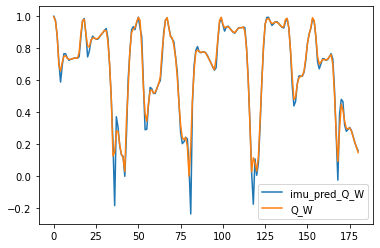

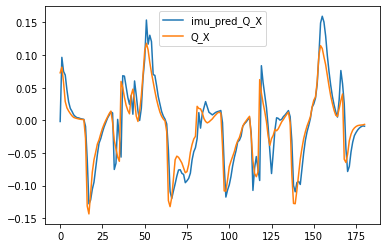

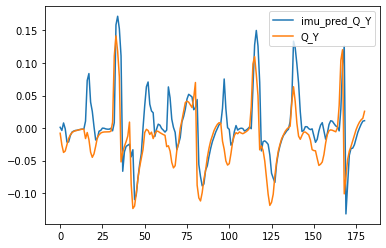

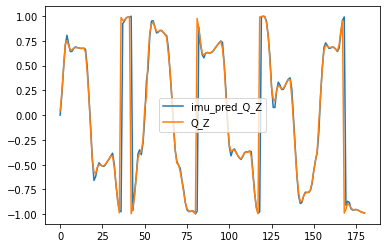

In [11]:
train_data[["imu_pred_Q_W", "Q_W"]].plot()
train_data[["imu_pred_Q_X", "Q_X"]].plot()
train_data[["imu_pred_Q_Y", "Q_Y"]].plot()
train_data[["imu_pred_Q_Z", "Q_Z"]].plot()

In [12]:
relative_imu_orientations = pd.DataFrame(train_data["imu_relative_orientation"].to_list(), columns=["imu_rel_Q_W", "imu_rel_Q_X","imu_rel_Q_Y","imu_rel_Q_Z"])
train_data = pd.concat([train_data, relative_imu_orientations], axis=1)

## Compare true relative poses and relative poses derived from IMU

<AxesSubplot:>

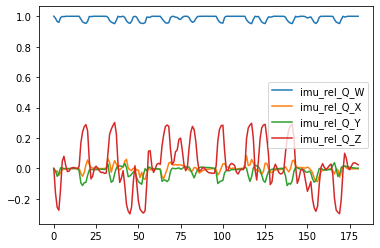

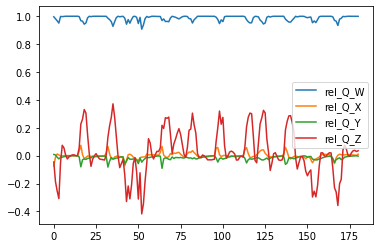

In [13]:
train_data[["imu_rel_Q_W", "imu_rel_Q_X","imu_rel_Q_Y","imu_rel_Q_Z"]].plot()
train_data[["rel_Q_W", "rel_Q_X","rel_Q_Y","rel_Q_Z"]].plot()

<AxesSubplot:>

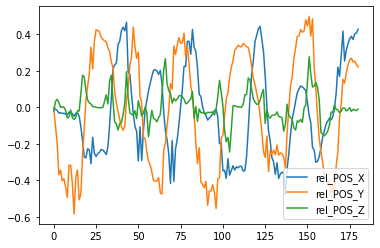

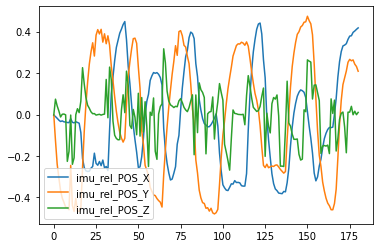

In [14]:
train_data[["rel_POS_X", "rel_POS_Y","rel_POS_Z"]].plot()
train_data[["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"]].plot()

<AxesSubplot:>

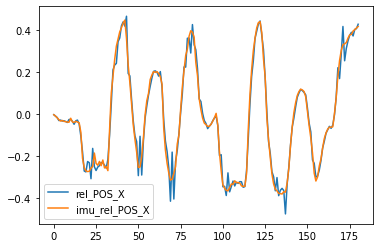

In [15]:
train_data[["rel_POS_X", "imu_rel_POS_X"]].plot()

<AxesSubplot:>

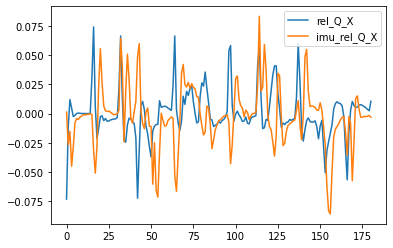

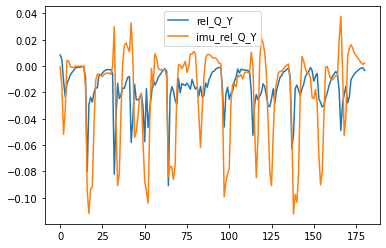

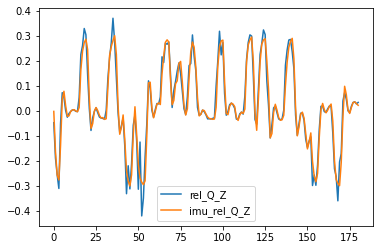

In [16]:
train_data[["rel_Q_X", "imu_rel_Q_X"]].plot()
train_data[["rel_Q_Y", "imu_rel_Q_Y"]].plot()
train_data[["rel_Q_Z", "imu_rel_Q_Z"]].plot()

## Check Reverse Calculation to obtain absolute pose

In [26]:
absolute_pose_c1 = train_data.apply(lambda row: np.hstack([row["POS_X"], row["POS_Y"], row["POS_Z"], row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]]), axis=1)
reverse_calculated = train_data.apply(lambda row: 
                                        obtain_absolute_pose(
                                            np.hstack([row["prev_POS_X"], row["prev_POS_Y"], row["prev_POS_Z"], row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
                                            row["relative_pose"]
                                        ), axis=1)

In [27]:
print(absolute_pose_c1.iloc[0] == reverse_calculated.iloc[0])
print(absolute_pose_c1.iloc[2],reverse_calculated.iloc[2])

[ True  True  True False False False False]
[-7.44221258 -6.99072456 -2.88065076  0.88028228  0.05799905 -0.0374499
  0.46940041] [-7.44221258 -6.99072456 -2.88065076  0.88028227  0.05799905 -0.0374499
  0.4694004 ]


In [28]:
absolute_pose_c1 = train_data.apply(lambda row: np.hstack([row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]]), axis=1)
reverse_calculated = train_data.apply(lambda row: 
                                        obtain_absolute_orientation(
                                            np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
                                            row["imu_relative_orientation"]
                                        ), axis=1)

In [29]:
print(absolute_pose_c1.iloc[2] == reverse_calculated.iloc[2])
print(absolute_pose_c1.iloc[2],reverse_calculated.iloc[2])

[False False False False]
[ 0.88028228  0.05799905 -0.0374499   0.46940041] [ 0.99449991  0.04533934 -0.09238995 -0.01945152]


<AxesSubplot:>

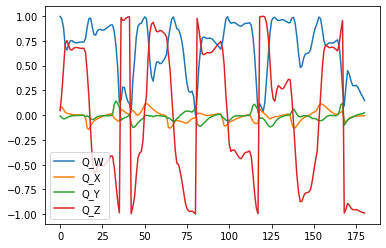

In [35]:
train_data[["Q_W","Q_X","Q_Y","Q_Z"]].plot()

<AxesSubplot:>

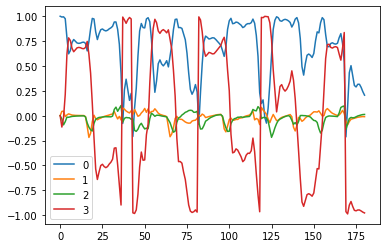

In [36]:
df = pd.DataFrame(reverse_calculated.to_list())
df.plot()

## Write to text file

In [ ]:
train_data = train_data[["ImageFile", "prev_ImageFile", 
                         "prev_LIN_VEL_X", "prev_LIN_VEL_Y", "prev_LIN_VEL_Z", "prev_LIN_ACC_X", "prev_LIN_ACC_Y", "prev_LIN_ACC_Z", "timestep",
                         "prev_ANG_VEL_X", "prev_ANG_VEL_Y", "prev_ANG_VEL_Z",
                         "rel_POS_X", "rel_POS_Y", "rel_POS_Z", "rel_Q_W", "rel_Q_X","rel_Q_Y","rel_Q_Z",
                         "imu_rel_POS_X", "imu_rel_POS_Y", "imu_rel_POS_Z", "imu_rel_Q_W", "imu_rel_Q_X","imu_rel_Q_Y","imu_rel_Q_Z"
                         ]]
train_data.to_csv(os.path.join(data_root, f'{train_or_val}.txt'), header=True, index=None, sep=' ', mode='w')

In [ ]:
train_data = pd.read_csv(os.path.join(data_root, f'train.txt'), sep=" ")
train_data[["rel_POS_X", "imu_rel_POS_X"]].plot()
train_data[["rel_Q_Z","imu_rel_Q_Z"]].plot()